## Title: Forecasting Spare parts inventory
## Client: NewX Services
## Project Ref: PM-PR-0027
#### Business Case: The case business case is on the inventory management. Keeping Inventory of spare in various service centre to the market demand is always a challenge as most service centres spends significant amount in spare parts inventory costs. In spite of this, availability of spare parts is been one of the problem areas.
#### GOAL: Create Predictive model for inventory forecasting so that service centre achieve JIT standards.¶¶
### Approach: Random Forest for Time Series Forecasting

In [1]:
# !pip install sqlalchemy
# !pip install pymysql

In [2]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6

import math

from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
from datetime import timedelta
import calendar

In [3]:
db_host = '18.136.157.135'
username = 'dm_usdata_sql'
user_pass = '37z<49REb&mKnl4AV!vJ'
db_name = 'project_service_data'

conn = create_engine('mysql+pymysql://'+username+':'+user_pass+'@'+db_host+'/'+db_name)
conn.table_names()

['service_data']

In [4]:
# Querying Table

query = "SELECT * FROM service_data"                                         
service = pd.read_sql(query,conn)
service.head(5)

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [5]:
# Grouping, object to datetime data type conversion, drop NaN values, sort and set date as index...

df=service.loc[:,['job_card_date', 'invoice_line_text']]
df.rename(columns={"job_card_date": "date", "invoice_line_text": "spares"}, inplace=True)
df= df.dropna()
# group by date
df=df.groupby(['date'], sort=True).count().reset_index()

In [6]:
df.tail(5)

,date,spares
548,31-08-17,35
549,31-10-17,54
550,31-10-18,67
551,31-12-17,64
552,31-12-18,81


In [7]:
# df.to_csv('Project_data/bike_service_data_grouped_by_date_3.csv', index=True)

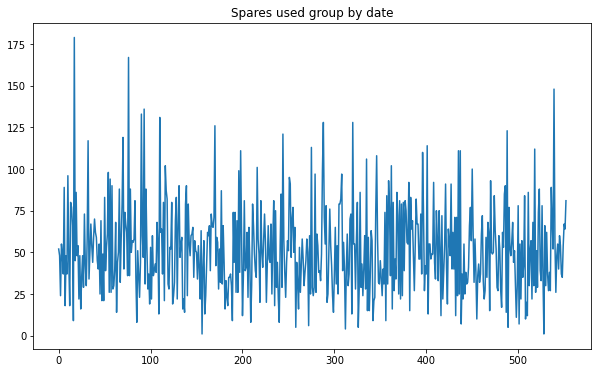

In [8]:
plt.plot(df.spares,label='Consumption')
plt.title('Spares used group by date')
plt.show(block=False)

## Check if the data is stationary

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.spares.dropna())
print('p-value: %f' % result[1])

p-value: 0.000000


In [10]:
## p < .001 that means the results were highly significant
## it suggestst there is zero chances of getting results if null hypothesis is true
## there is less chances of getting results

## Since the p-value is below 0.05, the data can be assumed to be stationary 
## hence we can proceed with the data without any transformation

## Create lag variables

In [11]:
dataframe = DataFrame()
for i in range(12, 0, -1):
   dataframe['t-' + str(i)] = df.spares.shift(i)
final_data = pd.concat([df, dataframe], axis=1)
final_data.dropna(inplace=True)
final_data

,date,spares,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
12,01-10-17,18,52.0,48.0,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0
13,01-10-18,80,48.0,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0
14,01-11-17,77,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0
15,01-11-18,66,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0,77.0
16,01-12-17,9,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0,77.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,31-08-17,35,89.0,68.0,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0
549,31-10-17,54,68.0,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0
550,31-10-18,67,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0,54.0
551,31-12-17,64,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0,54.0,67.0


In [12]:
try:
    pd.to_datetime(final_data['date'], format='%d-%m-%y', errors='raise')
    print("Correct date format [DD-MM-YY].")
except ValueError as e:
    print(e)
    pass

Correct date format [DD-MM-YY].


In [13]:
# converting [DD-MM-YY] into [DD-MM-YYYY]

final_data["date"]= pd.to_datetime(final_data["date"].astype(str),format='%f',dayfirst=True,infer_datetime_format=True)


In [14]:
final_data

,date,spares,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1
12,2017-10-01,18,52.0,48.0,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0
13,2018-10-01,80,48.0,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0
14,2017-11-01,77,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0
15,2018-11-01,66,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0,77.0
16,2017-12-01,9,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0,77.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,2017-08-31,35,89.0,68.0,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0
549,2017-10-31,54,68.0,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0
550,2018-10-31,67,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0,54.0
551,2017-12-31,64,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0,54.0,67.0


In [15]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 12 to 552
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    541 non-null    datetime64[ns]
 1   spares  541 non-null    int64         
 2   t-12    541 non-null    float64       
 3   t-11    541 non-null    float64       
 4   t-10    541 non-null    float64       
 5   t-9     541 non-null    float64       
 6   t-8     541 non-null    float64       
 7   t-7     541 non-null    float64       
 8   t-6     541 non-null    float64       
 9   t-5     541 non-null    float64       
 10  t-4     541 non-null    float64       
 11  t-3     541 non-null    float64       
 12  t-2     541 non-null    float64       
 13  t-1     541 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int64(1)
memory usage: 63.4 KB


In [16]:
# validating date format for [yyyy-mm-dd]
# time data 01-02-18 doesn't match format specified

try:
    pd.to_datetime(final_data['date'], format='%f', errors='raise')
    print("Correct date format.")
except ValueError as e:
    print(e)
    pass

Correct date format.


In [17]:
# df.to_csv('Project_data/bike_service_data_grouped_by_date_3.1.csv', index=True)

## Add seasonal variable

In [18]:
## Creation of a variable that has different values for different months which will 
## add a seasonal component to the model, which may help improve the forecast

In [19]:
final_data['date'] = pd.to_datetime(final_data['date'])
final_data['month'] = final_data['date'].dt.month

In [20]:
final_data

,date,spares,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,month
12,2017-10-01,18,52.0,48.0,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,10
13,2018-10-01,80,48.0,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,10
14,2017-11-01,77,24.0,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0,11
15,2018-11-01,66,55.0,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0,77.0,11
16,2017-12-01,9,49.0,37.0,89.0,18.0,48.0,37.0,96.0,45.0,18.0,80.0,77.0,66.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,2017-08-31,35,89.0,68.0,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,8
549,2017-10-31,54,68.0,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0,10
550,2018-10-31,67,52.0,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0,54.0,10
551,2017-12-31,64,148.0,57.0,26.0,48.0,55.0,40.0,60.0,54.0,37.0,35.0,54.0,67.0,12


## Train the model

In [21]:
# We will take the most recent 6 months data as the test dataset 
# and the rest of the data as the training dataset

In [22]:
finaldf = final_data.drop(['date'], axis=1)
finaldf = finaldf.reset_index(drop=True)
test_length=6
end_point = len(finaldf)
x = end_point - test_length
finaldf_train = finaldf.loc[:x - 1, :]
finaldf_test = finaldf.loc[x:, :]
finaldf_test_x = finaldf_test.loc[:, finaldf_test.columns != 'spares']
finaldf_test_y=finaldf_test['spares']
finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'spares']
finaldf_train_y = finaldf_train['spares']
print("Starting model train..")
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), 4)
fit = rfe.fit(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)

Starting model train..


C:\Users\Thiri\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [23]:
## RFE (recursive feature elimination) is beinf used to limit the number of independent 
# variables/features to 4, you can change the value and choose the value that gives 
# the least error. I have taken n_estimators (number of trees in the forest) 100 
# which is the default value.

## Evaluating the Algorithm

In [24]:
y_true = np.array(finaldf_test_y)
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')

Accuracy: 75.84 %.


# Predict for Future

# We will predicting spares for future 6 months. 
# The lags will be null for future date points so we have to predict for one month at a time and use the predicted spares for creating lag for next month’s prediction and so on.
# Please note we are using the predicted spraes only to create the lag variable, we will not train the model again.

In [25]:
def add_month(df, forecast_length, forecast_period):
    end_point = len(df)
    df1 = pd.DataFrame(index=range(forecast_length), columns=range(2))
    df1.columns = ['spares', 'date']
    df = df.append(df1)
    df = df.reset_index(drop=True)
    x = df.at[end_point - 1, 'date']
#     x = pd.to_datetime(x, format='%d-%m-%Y')
#     x = pd.to_datetime(x, format='%f')
    x = pd.to_datetime(x, format='%d-%m-%Y', dayfirst=True, infer_datetime_format=True)
    days_in_month=calendar.monthrange(x.year, x.month)[1]
    if forecast_period == 'Week':
        for i in range(forecast_length):
            df.at[df.index[end_point + i], 'date'] = x + timedelta(days=7 + 7 * i)
            df.at[df.index[end_point + i], 'spares'] = 0
    elif forecast_period == 'Month':
        for i in range(forecast_length):
            df.at[df.index[end_point + i], 'date'] = x + timedelta(days=days_in_month + days_in_month * i)
            df.at[df.index[end_point + i], 'spares'] = 0
#     df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')
#     df['date'] = pd.to_datetime(df['date'], format='%f')
    df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y', dayfirst=True, infer_datetime_format=True)
    df['month'] = df['date'].dt.month
    df = df.drop(['date'], axis=1)
    return df
def create_lag(df3):
    dataframe = DataFrame()
    for i in range(12, 0, -1):
        dataframe['t-' + str(i)] = df3.spares.shift(i)
    df4 = pd.concat([df3, dataframe], axis=1)
    df4.dropna(inplace=True)
    return df4
def randomForest(df1, forecast_length, forecast_period):
    df3 = df1[['spares', 'date']]
    df3 = add_month(df3, forecast_length, forecast_period)
    finaldf = create_lag(df3)
    finaldf = finaldf.reset_index(drop=True)
    n = forecast_length
    end_point = len(finaldf)
    x = end_point - n
    finaldf_train = finaldf.loc[:x - 1, :]
    finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'spares']
    finaldf_train_y = finaldf_train['spares']
    print("Starting model train..")
    rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), 4)
    fit = rfe.fit(finaldf_train_x, finaldf_train_y)
    print("Model train completed..")
    print("Creating forecasted set..")
    yhat = []
    end_point = len(finaldf)
    n = forecast_length
    df3_end = len(df3)
    for i in range(n, 0, -1):
        y = end_point - i
        inputfile = finaldf.loc[y:end_point, :]
        inputfile_x = inputfile.loc[:, inputfile.columns != 'spares']
        pred_set = inputfile_x.head(1)
        pred = fit.predict(pred_set)
        df3.at[df3.index[df3_end - i], 'spares'] = pred[0]
        finaldf = create_lag(df3)
        finaldf = finaldf.reset_index(drop=True)
        yhat.append(pred)
    yhat = np.array(yhat)
    print("Forecast complete..")
    return yhat

In [26]:
predicted_value=randomForest(df, 6, 'Month')

Starting model train..


C:\Users\Thiri\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=4 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Model train completed..
Creating forecasted set..
Forecast complete..


In [27]:
predicted_value

array([[36.72],
       [52.85],
       [48.67],
       [48.2 ],
       [45.97],
       [48.1 ]])

# Results: Despite the input data chalanges the random forest model works better for even time series problems with optimal accuracy.